In [52]:
from tensorflow import keras
import numpy as np
import PIL
import pandas as pd
import os 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

## Functions

In [53]:
def show_image_grid(images,title,size=(2,2)):
  images = images.astype(int)
  fig = plt.figure(figsize=(8,8))
  grid = ImageGrid(fig, "111", size)
  for ax, x in zip(grid,images):
    ax.imshow(x)
  
  fig.suptitle(title,fontsize=28,y=1.0)
  plt.show()

def show_performance(data,model,p=0.5,gridsize=2):
  data=data.shuffle(1000).as_numpy_iterator()
  features, labels = next(data)
  features = features.astype(int)

  logits=model.predict(features)
  preds=logits>p
  preds=np.ravel(preds)

  fp = np.logical_and(preds !=labels, preds)
  fp_imgs = features[np.where(fp)]

  fn = np.logical_and(preds!=labels, np.logical_not(preds))
  fn_imgs = features[np.where(fn)]

  tp_g = np.logical_and(preds==labels,preds)
  tp_g_imgs = features[np.where(tp_g)]

  tp_h =np.logical_and(preds==labels, np.logical_not(preds))
  tp_h_imgs = features[np.where(tp_h)]
  
  while any([not(len(i) >=gridsize**2) for i in [tp_g_imgs,tp_h_imgs,fn_imgs,fp_imgs]]):
    
    features, labels = next(data)
    features = features.astype(int)

    logits=model.predict(features)
    preds=logits>p
    preds=np.ravel(preds)

    fp = np.logical_and(preds !=labels, preds)
    fp_imgs = np.concatenate([features[np.where(fp)],fp_imgs])

    fn = np.logical_and(preds!=labels, np.logical_not(preds))
    fn_imgs = np.concatenate([features[np.where(fn)],fn_imgs])

    tp_g = np.logical_and(preds==labels,preds)
    tp_g_imgs =np.concatenate([features[np.where(tp_g)],tp_g_imgs])

    tp_h =np.logical_and(preds==labels, np.logical_not(preds))
    tp_h_imgs =np.concatenate([features[np.where(tp_h)],tp_h_imgs])
  

 

  show_image_grid(fp_imgs,f'False positive images @p={p}',size=(gridsize,gridsize))
  print('\n'*4)
  show_image_grid(fn_imgs,f'False negative images @p={p}',size=(gridsize,gridsize))
  print('\n'*4)
  show_image_grid(tp_g_imgs,f'True positive images \nidentifying weapon holder @p={p}',size=(gridsize,gridsize))
  print('\n'*4)
  show_image_grid(tp_h_imgs,f'True positive images \nidentifying non weapon holder @p={p}',size=(gridsize,gridsize))


In [19]:
import PIL
import os 

def _load_image(filename):
    return Image.open(filename).convert('RGB') #this conversion is crucial as PIL will open png files with either 3 or 4 channels depending on encoding

def center_crop(img):
    '''Algorithm derived from nvidia preprocessor'''
    crop = np.min(img.shape[:2])
    img = img[(img.shape[0]-crop)//2:(img.shape[0]+crop)//2,(img.shape[1]-crop)//2:(img.shape[1]+crop)//2]
    img = Image.fromarray(img,'RGB')
    return img

def resize_and_crop(fp,width,height):
    img=np.asarray(_load_image(fp),dtype=np.uint8)
    img=center_crop(img)
    
#     if img.size[1]<height or img.size[0]<width:
#         print('here')
#         print(fp)
    
    img=img.resize((width,height),Image.LANCZOS)
    img=np.array(img)
    
    canvas = np.zeros([width,width,3],dtype=np.uint8)
    canvas[(width-height)//2: (width+height)//2,:]=img
    return canvas 
def get_files_with_image_endings(fp):
    img_endings = ['.png','.jpg','.jpeg']
    files = [i for i in os.listdir(fp) if any([i.endswith(ending) for ending in img_endings])]
    return files
def load_image(path):
    return np.array(PIL.Image.open(path).convert('RGB'),dtype=np.uint8)
def load_image_folder(path):
    files=get_files_with_image_endings(path)
    return np.array([load_image(os.path.join(path,i)) for i in files])

## Load and Test Model

In [23]:
model = keras.models.load_model('final_model')

In [25]:
adversarial_images=load_image_folder('custom_data/adverse')

In [40]:
adversarial_predictions=model.predict(adversarial_images,batch_size=32)

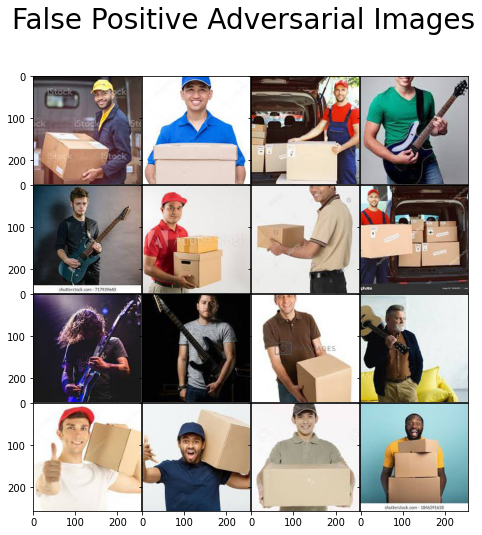

In [56]:
show_image_grid(adversarial_images[np.where(np.ravel(adversarial_predictions>0.5))[:16]],'False Positive Adversarial Images', (4,4))


In [36]:
oos_images=keras.utils.image_dataset_from_directory('custom_data/out_of_sample',image_size=(256,256))

Found 205 files belonging to 2 classes.


In [42]:
performance_oos=model.evaluate(oos_images,return_dict = True)
for i in performance_oos:
  performance_oos[i]=[performance_oos[i]]
performance_oos=pd.DataFrame(performance_oos)

7/7 [==============================] - 55s 8s/step - loss: 0.3351 - tp: 152.0000 - fp: 24.0000 - tn: 19.0000 - fn: 10.0000 - accuracy: 0.8341 - precision: 0.8636 - recall: 0.9383 - auc: 0.8819 - prc: 0.9680


In [43]:
performance_oos

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,0.335115,152.0,24.0,19.0,10.0,0.834146,0.863636,0.938272,0.881855,0.967982


In [54]:
performance_adv=model.evaluate(adversarial_images,np.zeros(len(adversarial_images)),return_dict = True)
for i in performance_adv:
  performance_adv[i]=[performance_adv[i]]
performance_adv=pd.DataFrame(performance_adv)

5/5 [==============================] - 30s 6s/step - loss: 1.6791 - tp: 0.0000e+00 - fp: 91.0000 - tn: 44.0000 - fn: 0.0000e+00 - accuracy: 0.3259 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00


In [50]:
performance_adv

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,1.679126,0.0,91.0,44.0,0.0,0.325926,0.0,0.0,0.0,0.0


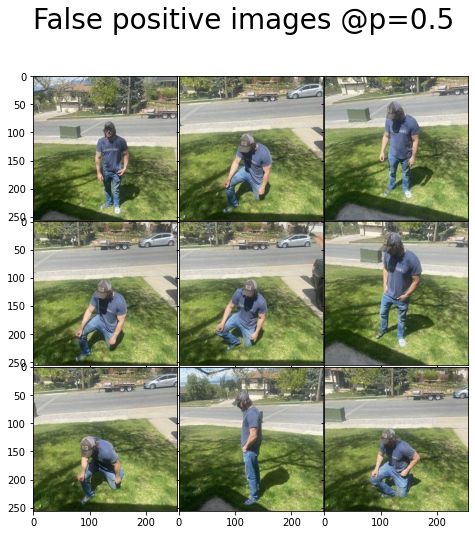

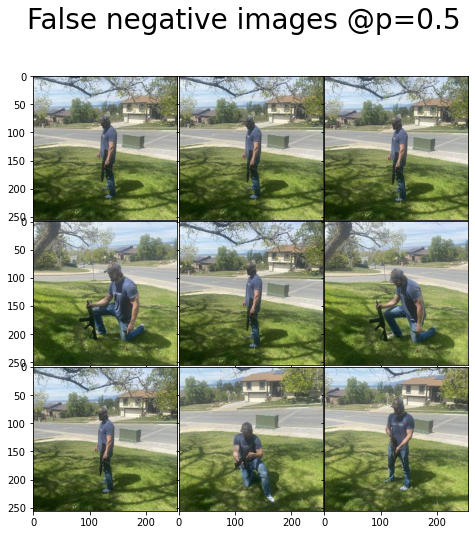

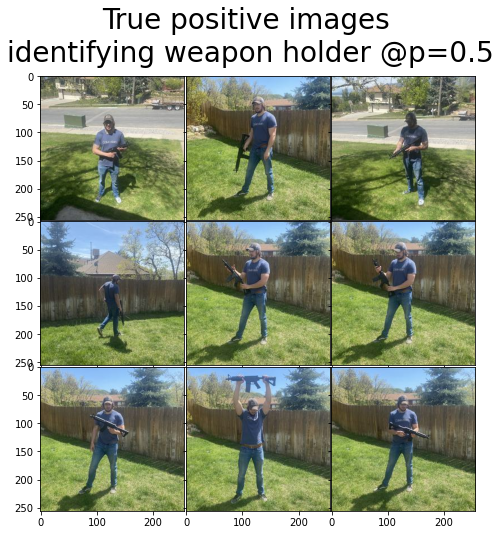

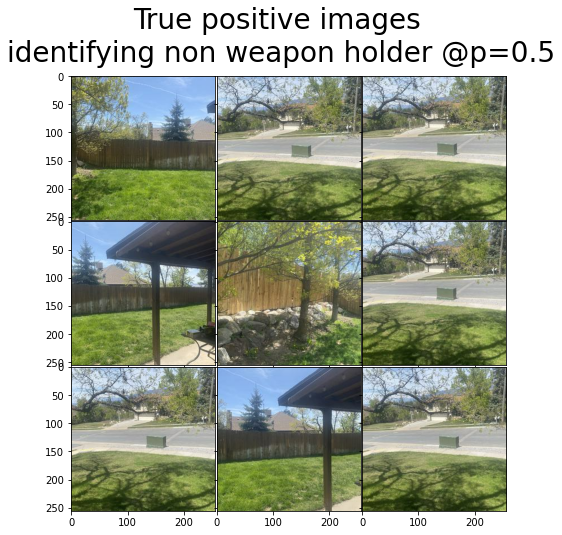

In [57]:
show_performance(oos_images,model,gridsize=3)
